## spxs: 解释

open是股票开盘价
high是当天股票的价格最高点
close是当天股票的收盘价
adj close是当天股票的调整后的收盘价
low是当天股票的价格最低点
volume交易额

In [2]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("A").config("B", "C").getOrCreate()
sc=spark.sparkContext

In [3]:
import pandas as pd
stock = pd.read_csv("./data/SPXS.csv")
stock.tail(4)
# 253即交易日的个数

,Date,Open,High,Low,Close,Adj Close,Volume
250,2020-07-27,6.84,6.90,6.72,6.73,6.73,21540600
251,2020-07-28,6.79,6.89,6.71,6.87,6.87,27096500
252,2020-07-29,6.81,6.81,6.57,6.60,6.60,22205300
253,2020-07-30,6.81,6.84,6.77,6.82,6.82,4638764


In [4]:
stock["Date"] = pd.to_datetime(stock["Date"])
# 这样可以算两个日期之间有多少个交易日

In [5]:
type(stock["Date"][0])

pandas._libs.tslibs.timestamps.Timestamp

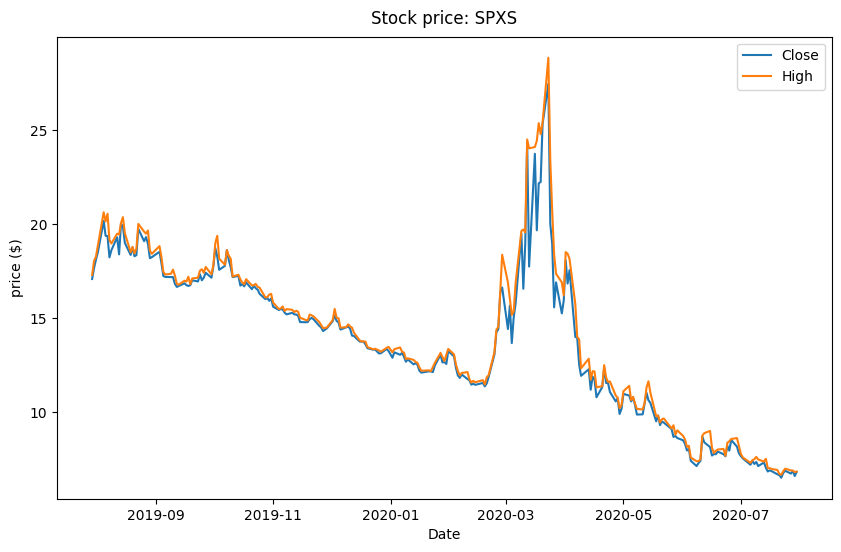

In [6]:
import matplotlib.pyplot as plt
ticker = 'SPXS'
width = 10
height = 6
data = stock
fig = plt.figure(figsize=(width, height))
ax = fig.add_subplot(1, 1, 1)
ax.plot(data.Date, data.Close, label='Close')
ax.plot(data.Date, data.High, label='High')
# ax.plot(data.Date, data.Low, label='Low')
ax.set_xlabel('Date')
ax.set_ylabel('price ($)')
ax.legend()
ax.set_title('Stock price: ' + ticker, y=1.01)
# plt.xticks(rotation=70)
plt.show()


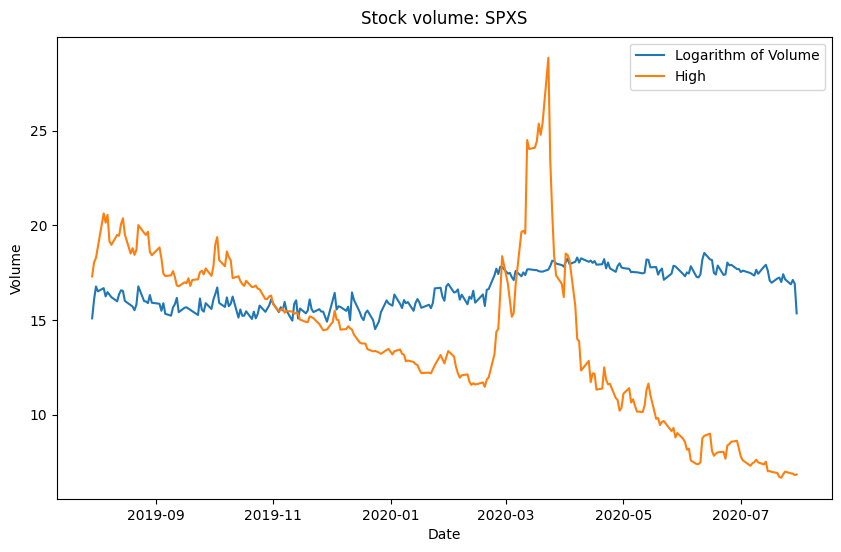

In [7]:
import numpy as np
fig = plt.figure(figsize=(width, height))
ax = fig.add_subplot(1, 1, 1)
ax.plot(data.Date, np.log(data.Volume), label='Logarithm of Volume')
ax.plot(data.Date, data.High, label='High')
ax.set_xlabel('Date')
ax.set_ylabel('Volume')
ax.legend()
ax.set_title('Stock volume: ' + ticker, y=1.01)
# plt.xticks(rotation=70)
plt.show()

In [8]:
days = (stock.Date.iloc[-1] - stock.Date.iloc[0]).days  # 这中间有多少天
cagr = ((((stock['Adj Close'].iloc[-1]) /
        stock['Adj Close'].iloc[0])) ** (365.0/days)) - 1  #CAGR的定义：(end/start)^{365/days}-1
print('CAGR =', str(round(cagr, 4)*100)+"%")
mu = cagr #求出了均值


CAGR = -59.699999999999996%


In [9]:
stock['Returns'] = stock['Adj Close'].pct_change()  # 这样就自动计算出了收益率
# 收益率：R_i=(P_i-P_{i-1})/P_{i-1}，服从正态分布
vol = stock['Returns'].std()*np.sqrt(252)  # 得到一年的
# 波动率：股票收益率的标准差
stock.head(4)

,Date,Open,High,Low,Close,Adj Close,Volume,Returns
0,2019-07-30,17.240000,17.299999,17.010000,17.080000,16.964201,3564900,NaN
1,2019-07-31,17.049999,18.040001,17.010000,17.660000,17.540268,9546600,0.033958
2,2019-08-01,17.650000,18.280001,17.059999,18.120001,17.997150,19209100,0.026048
3,2019-08-02,18.320000,18.860001,18.270000,18.510000,18.384506,14807700,0.021523


#### 想用P_n预测P_{n+1},...,P_{n+5}

- 先产生R_{n+1},...,R_{n+5}的随机数
- $P_{n+1}=P_n*R_{n+1}+P_n=P_n*(R_{n+1}+1)$
- 顺次迭代则可

In [10]:
# 产生RDD随机数
# starting stock price (i.e. last available real stock price)
from pyspark.mllib.random import RandomRDDs
S = stock['Adj Close'].iloc[-1]
T = 5  # Number of trading days，预测5步
mu = cagr  # Return，收益率的均值
vol = vol  # Volatility，波动率，收益率的标准差
trials = 10000

mat = RandomRDDs.normalVectorRDD(sc, trials, T, seed=1)


In [11]:
import math
a = mu/T
b = vol/math.sqrt(T)
#标准化一下
v = mat.map(lambda x: a + b*x) #将标准正态分布转为N(mu,sig^2)

# from pyspark.sql.functions import round
df = v.map(lambda x: [float(round(i, 6)+1) for i in x]).toDF()
#+1咋来的：收益率+1。那到时候直接用价格乘它就行
df.show(5)

+------------------+-------------------+------------------+------------------+--------+
|                _1|                 _2|                _3|                _4|      _5|
+------------------+-------------------+------------------+------------------+--------+
|           1.00886|           0.929954|          0.762711|          0.339345|0.787027|
|0.7269760000000001|           2.196122|1.3264909999999999|1.5353379999999999| 1.22516|
|0.7543610000000001|           0.590784|          1.104377|          1.729811|0.912783|
|          1.855906|0.23815299999999995|          1.480346|          1.013731|0.306581|
|          0.551161|           1.152047|0.6212409999999999|          0.705113|1.326988|
+------------------+-------------------+------------------+------------------+--------+
only showing top 5 rows



In [12]:
from pyspark.sql.functions import lit
S = stock['Adj Close'].iloc[-1]
price = df.withColumn('init_price', lit(S)) #看看？为什么
price.show(5) #用一个标量来填充一列，作为初始值

+------------------+-------------------+------------------+------------------+--------+----------+
|                _1|                 _2|                _3|                _4|      _5|init_price|
+------------------+-------------------+------------------+------------------+--------+----------+
|           1.00886|           0.929954|          0.762711|          0.339345|0.787027|      6.82|
|0.7269760000000001|           2.196122|1.3264909999999999|1.5353379999999999| 1.22516|      6.82|
|0.7543610000000001|           0.590784|          1.104377|          1.729811|0.912783|      6.82|
|          1.855906|0.23815299999999995|          1.480346|          1.013731|0.306581|      6.82|
|          0.551161|           1.152047|0.6212409999999999|          0.705113|1.326988|      6.82|
+------------------+-------------------+------------------+------------------+--------+----------+
only showing top 5 rows



In [13]:
from pyspark.sql.functions import col
#提取出某一列
price = price.withColumn('day_0', col('init_price'))
price.show(5)

+------------------+-------------------+------------------+------------------+--------+----------+-----+
|                _1|                 _2|                _3|                _4|      _5|init_price|day_0|
+------------------+-------------------+------------------+------------------+--------+----------+-----+
|           1.00886|           0.929954|          0.762711|          0.339345|0.787027|      6.82| 6.82|
|0.7269760000000001|           2.196122|1.3264909999999999|1.5353379999999999| 1.22516|      6.82| 6.82|
|0.7543610000000001|           0.590784|          1.104377|          1.729811|0.912783|      6.82| 6.82|
|          1.855906|0.23815299999999995|          1.480346|          1.013731|0.306581|      6.82| 6.82|
|          0.551161|           1.152047|0.6212409999999999|          0.705113|1.326988|      6.82| 6.82|
+------------------+-------------------+------------------+------------------+--------+----------+-----+
only showing top 5 rows



In [14]:
from pyspark.sql.functions import round

for name in price.columns[:-2]:
      price = price.withColumn('day'+name, round(col(name)*col('init_price'),2)) #保留两位因为钱只有分
      #迭代，两列相乘，价格乘上收益率＋1
      price = price.withColumn('init_price',col('day'+name))

In [15]:
selected_col = [name for name in price.columns if 'day_' in name]
simulated = price.select(selected_col)
simulated.describe().show()

selected_col

+-------+-----------------+-----------------+-----------------+-----------------+-----------------+------------------+
|summary|            day_0|            day_1|            day_2|            day_3|            day_4|             day_5|
+-------+-----------------+-----------------+-----------------+-----------------+-----------------+------------------+
|  count|            10000|            10000|            10000|            10000|            10000|             10000|
|   mean|6.819999999999884|         6.008217|5.275942000000001|4.623524000000001|4.052257999999998|3.5805089999999984|
| stddev|              0.0|3.047584444770285|3.977219018327754|4.564736794561584|4.930770070768367| 5.274461703865672|
|    min|             6.82|            -4.97|             -7.4|            -9.49|           -10.16|            -13.21|
|    max|             6.82|             17.4|            26.77|            42.88|            57.35|              66.9|
+-------+-----------------+-----------------+---

['day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5']